# Peer-graded Assignment: Описательный анализ данных

Часто при работе с пользовательскими данными приходится сталкиваться с тем, что данные предоставляются для работы без описания. При этом не известно, что содержательно представляют собой те или иные признаки, а известны лишь их типы: числовые, категориальные, номинальные переменные. Такие ситуации - не редкость при работе с «чувствительными» данными, например, в сфере банковской аналитики, HR-аналитики, сфере телекоммуникаций, страхования, здравоохранения, недвижимости или ритейла. Тем не менее, с такими данным нужно уметь работать, и нужно уметь проводить на них классические этапы анализа, в частности описательный анализ данных и визуализацию. Именно этим мы займемся на первой неделе.


В этом задании мы потренируемся делать описательный анализ и визуализацию так называемых «закрытых» данных - данных, которые предоставляются для анализа и построения моделей без описания. Выборка, с которой мы будем работать прилагается.

* Метки классов (здесь `1` соответствует классу `отток`, `-1` - классу `не отток`) – `orange_small_churn_labels.train`
* Данные (предоставлены без описания, однако известно, что первые 190 переменных являются числовыми, а оставшиеся 40 - категориальными) – `orange_small_churn_data.train`

Скачайте файлы [на странице задания] и переходите к выполнению задачи! Результатом выполнения задания является jupyter notebook. Перед отправкой результата убедитесь, что вы выполнили все пункты из задания и это можно понять из вашего notebook'а. Проверьте, что код написан понятно и аккуратно - это поможет вашим сокурсником лучше понять, что вы сделали, и оценить вашу работу.

## Инструкции

1\. Загрузите данные `orange_small_churn_data.train` и `orange_small_churn_labels.train`

In [38]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv('orange_small_churn_data.train')
labels = pd.read_csv('orange_small_churn_labels.train', header = None, names = ['val'])

In [3]:
print(data.shape)
print(labels.shape)

(40000, 230)
(40000, 1)


In [4]:
data.head()

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,...,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230
0,NaN,NaN,NaN,NaN,NaN,3052.0,NaN,NaN,NaN,NaN,...,Al6ZaUT,vr93T2a,LM8l689qOp,NaN,NaN,fKCe,02N6s8f,xwM2aC7IdeMC0,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,1813.0,7.0,NaN,NaN,NaN,...,oslk,6hQ9lNX,LM8l689qOp,NaN,ELof,xb3V,RAYp,55YFVY9,mj86,NaN
2,NaN,NaN,NaN,NaN,NaN,1953.0,7.0,NaN,NaN,NaN,...,zCkv,catzS2D,LM8l689qOp,NaN,NaN,FSa2,ZI9m,ib5G6X1eUxUn6,mj86,NaN
3,NaN,NaN,NaN,NaN,NaN,1533.0,7.0,NaN,NaN,NaN,...,oslk,e4lqvY0,LM8l689qOp,NaN,NaN,xb3V,RAYp,F2FyR07IdsN7I,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,686.0,7.0,NaN,NaN,NaN,...,oslk,MAz3HNj,LM8l689qOp,NaN,NaN,WqMG,RAYp,F2FyR07IdsN7I,NaN,NaN


In [5]:
labels.head()

,val
0,-1
1,-1
2,-1
3,1
4,-1


По условию задания, первые 190 признаков - вещественные, поэтому сразу выделим наименование этих столбцов в отдельную переменную numeric_cols, а категориальные  - categorical_cols.

In [6]:
numeric_cols = data.columns.values[:190]
categorical_cols = list(set(data.columns.values.tolist()) - set(numeric_cols))

2\. Рассчитайте доли классов `отток` и `не отток`.

In [8]:
print(labels['val'].value_counts(normalize = True))

-1    0.9256
 1    0.0744
Name: val, dtype: float64


3\. Рассчитайте корреляции переменных с целевой функцией и проанализируйте полученные данные.

Обратите внимание на то, что целевая функция предсталвляет собой бинарную переменную. Теоретически, это не помешает рассчиать, например, корреляцию Пирсона между непрерывной переменной и целевой функцией, онднако анализиоовать полученные результаты будет сложно, корреляция Пирсона просто не рассчитана на такое применение. Кто уже забыл, как действовать в такой ситуации - вспоминить можно вот здесь: https://stepik.org/lesson/90035/step/3?unit=66281 

Мерой силы взаимосвязи между непрерывной и бинарной переменной может служить разность математических ожиданий непрерывной переменной при разных значениях бинарной переменной:

In [28]:
Corr_churn_mean = data[numeric_cols].loc[labels['val'] == 1].mean()
Corr_not_churn_mean = data[numeric_cols].loc[labels['val'] == -1].mean()

numeric_corr = Corr_churn_mean - Corr_not_churn_mean

Для целевой и категориальных переменных создадим функцию для расчета коэффициент V-Крамера.

In [12]:
#Create V-Cramer function
import numpy as np
from scipy.stats import chi2_contingency

def V_Cramers(X):
    chi_2 = chi2_contingency(X)[0]
    n = np.sum(X)
    k1,k2 = X.shape
    return np.sqrt(chi_2/(n*(np.min([k1,k2])-1)))

Рассчитаем коэффициент V-Крамера, аналогично числовым признакам, создав словарь в котором ключ - наименование признака, а значение  - коэффициент V-Крамера. 

In [72]:
categorical_corr = {}

for col in categorical_cols:
    df = pd.crosstab(data[col].values, labels['val'].values.reshape((labels['val'].shape[0])))
    if df.values.shape != (0,0):
        categorical_corr[col] = V_Cramers(df.values)
    else:
        categorical_corr[col] = None

/anaconda2/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in true_divide
  if __name__ == '__main__':


4\. Визуализируйте данные: рассмотрите топ 20 числовых переменных, наиболее сильно коррелирующих с целевой функцией. Для этих переменных постройте:
* Распределения в разрезе классов
* Отобразите объекты в координатах пар признаков

Сортируем словаря:

In [31]:
top20_abs = numeric_corr.abs().sort_values(ascending = False)[:20]
top20 = numeric_corr[top20_abs.index]

Строим распределения в разрезе классов:

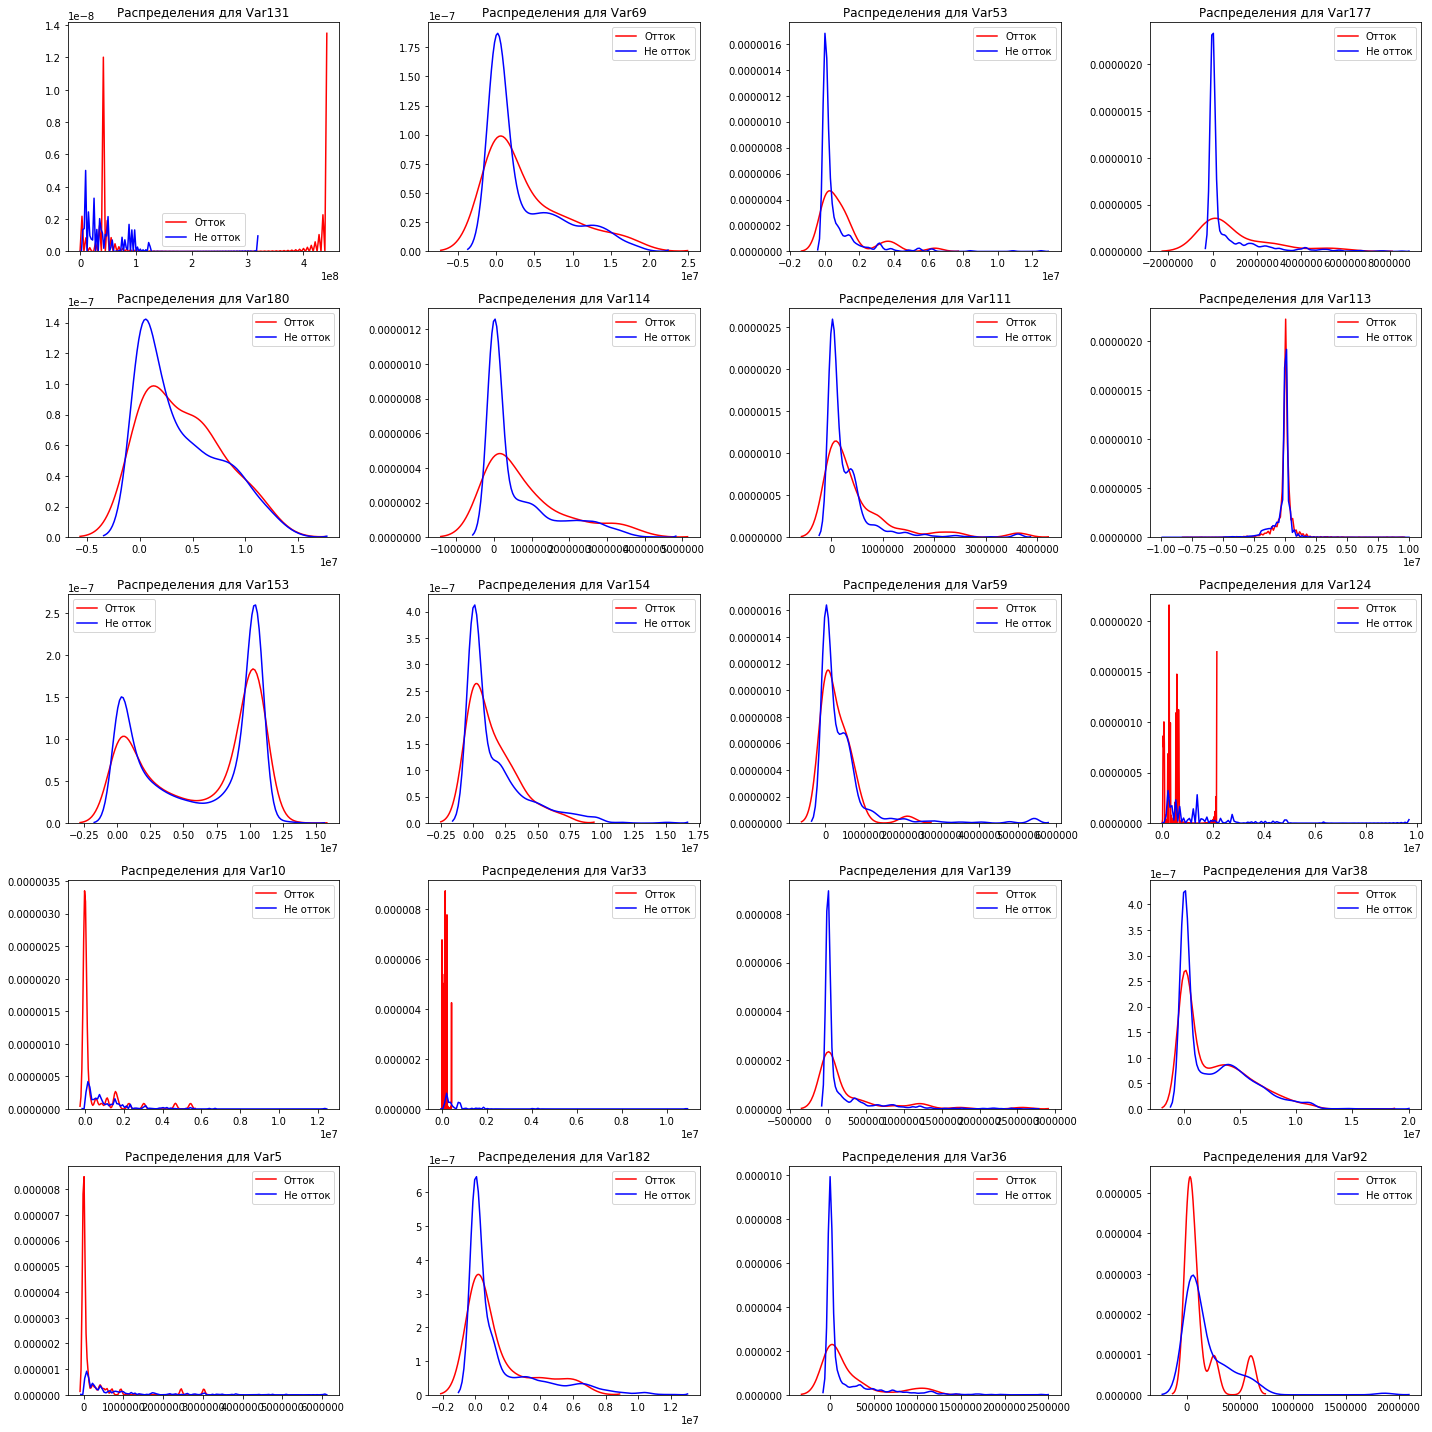

In [47]:
fig, axes = plt.subplots(5, 4, figsize=(20,20))

for i, var in enumerate(top20.index):
    var_churn = data[var].loc[labels['val'] == 1]
    var_not_churn = data[var].loc[labels['val'] == -1]
               
    sns.kdeplot(var_churn, color = 'r', ax = axes[int(i / 4) , i % 4], label = 'Отток')
    sns.kdeplot(var_not_churn, color = 'b', ax = axes[int(i / 4) , i % 4], label = 'Не отток')
    axes[int(i / 4), i % 4].set(title = 'Распределения для '+ var)
    
fig.tight_layout()

Отобразим ПЕРВЫЕ ШЕСТЬ объектов в координатах пар признаков для удобства первичного анализа:

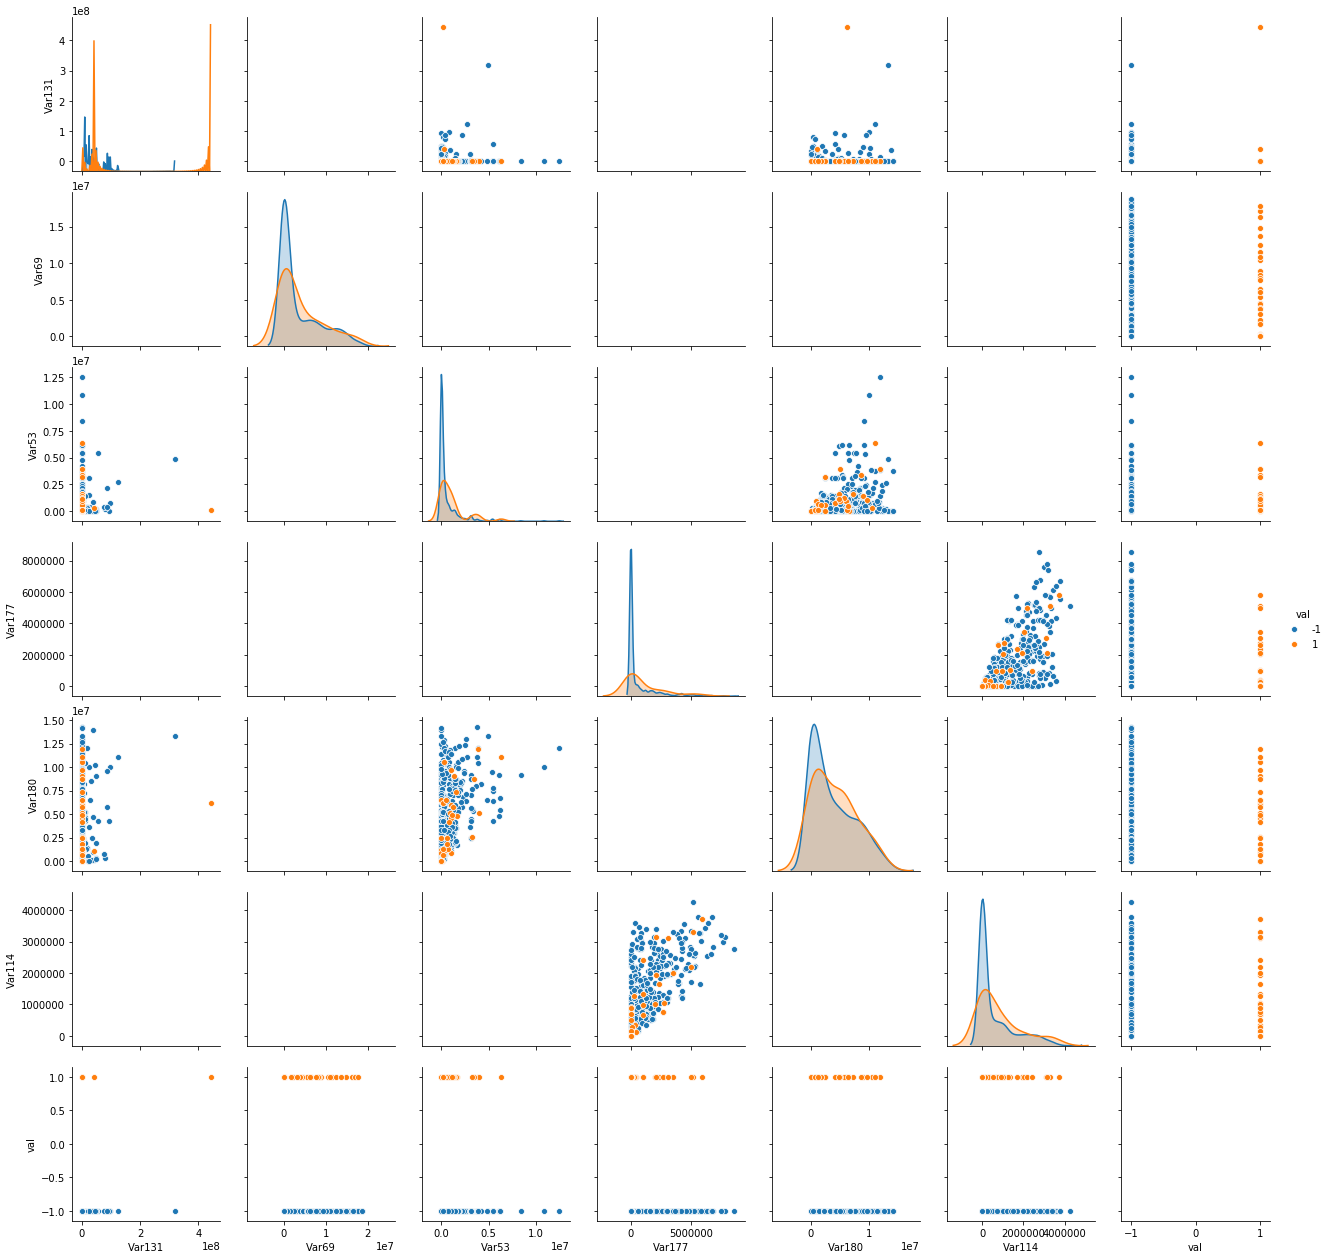

In [57]:
merged_df = pd.concat([data[top20.index[:6]], labels], axis = 1, sort=False)
sns.pairplot(merged_df, hue="val", diag_kind="kde")

5\. Проделайте аналогичные шаги для случайно выбранных 10 числовых признаков.

Генерируем случаные названия признаков:

In [59]:
random_cols = np.random.choice(numeric_cols, size=10, replace=False)
data_random = data[random_cols]

Строим распределения в разрезе классов:

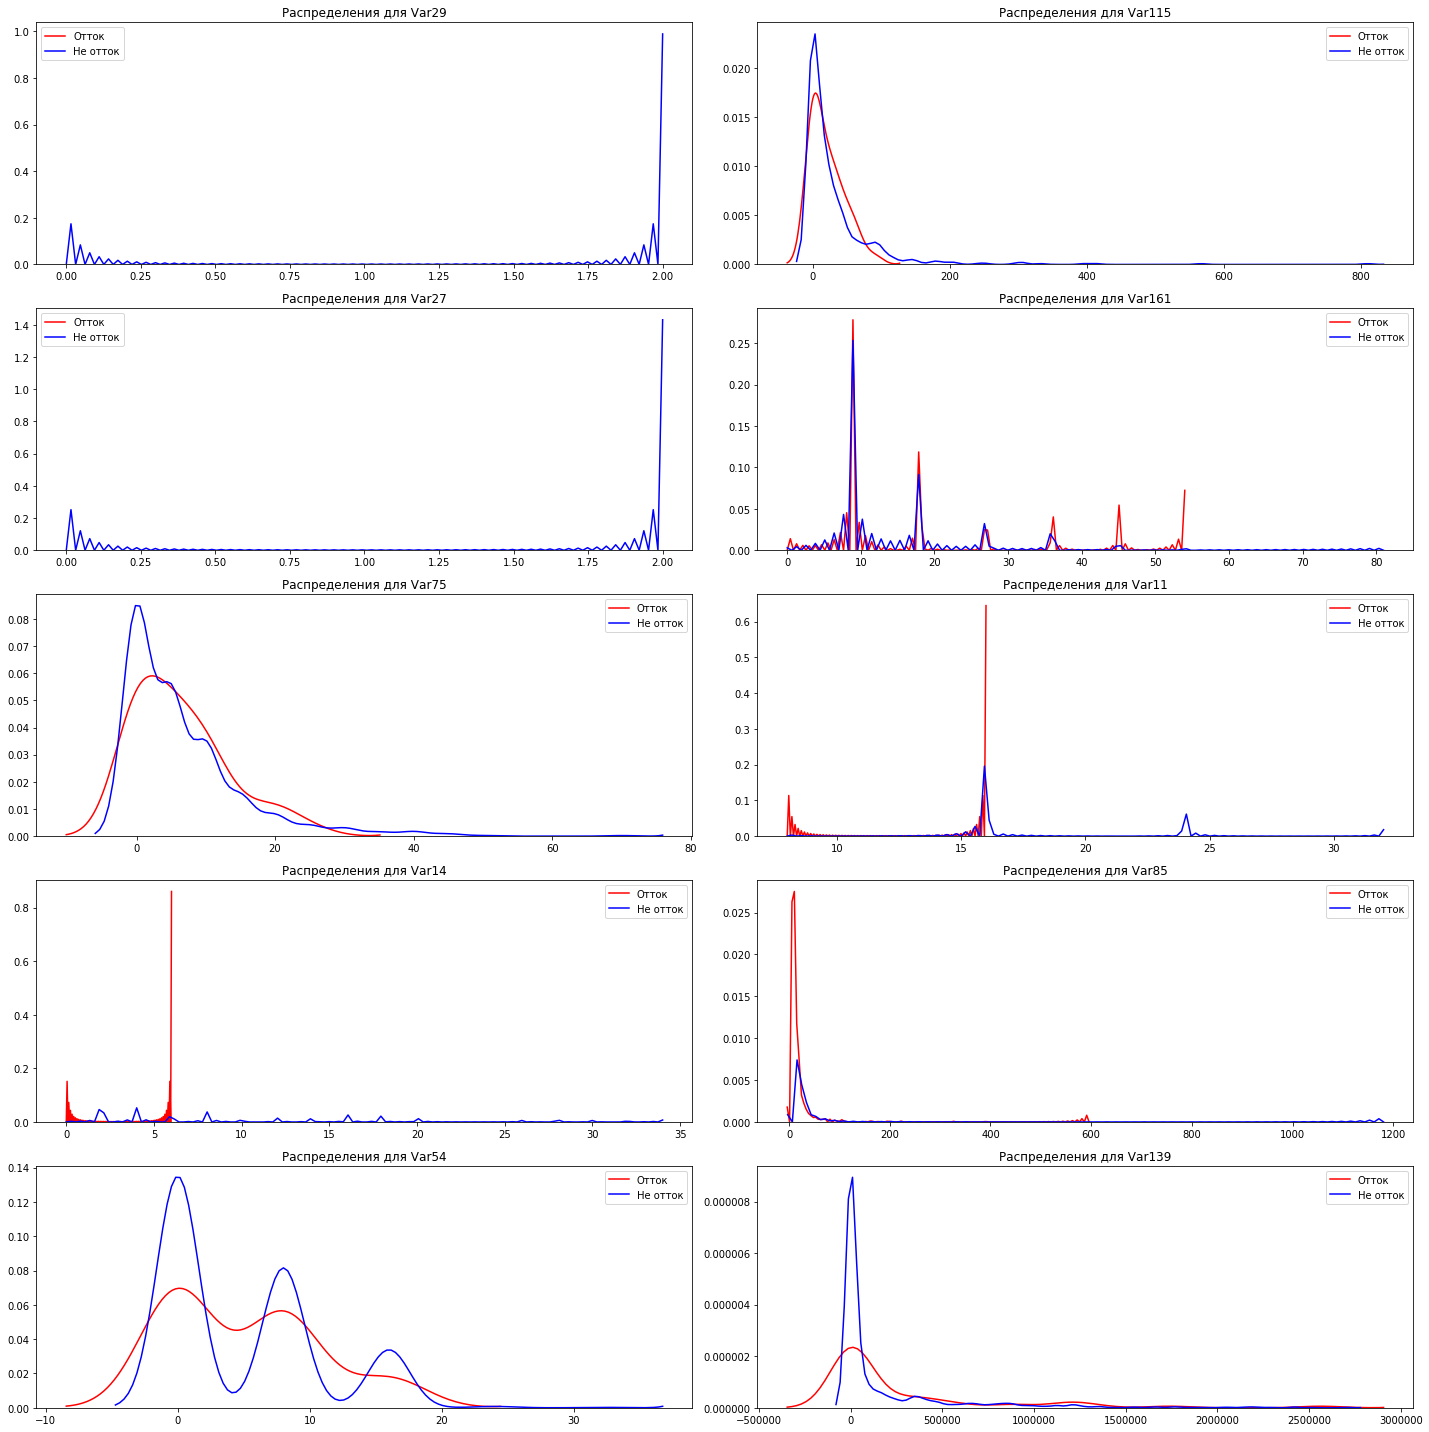

In [67]:
fig, axes = plt.subplots(5, 2, figsize = (20,20))

for i, var in enumerate(random_cols):
    var_churn = data[var].loc[labels['val'] == 1]
    var_not_churn = data[var].loc[labels['val'] == -1]
               
    sns.kdeplot(var_churn, color = 'r', ax = axes[int(i / 2) , i % 2], label = 'Отток')
    sns.kdeplot(var_not_churn, color = 'b', ax = axes[int(i / 2) , i % 2], label = 'Не отток')
    axes[int(i / 2), i % 2].set(title = 'Распределения для '+ var)
    
fig.tight_layout()

Отобразим объекты в координатах пар признаков:

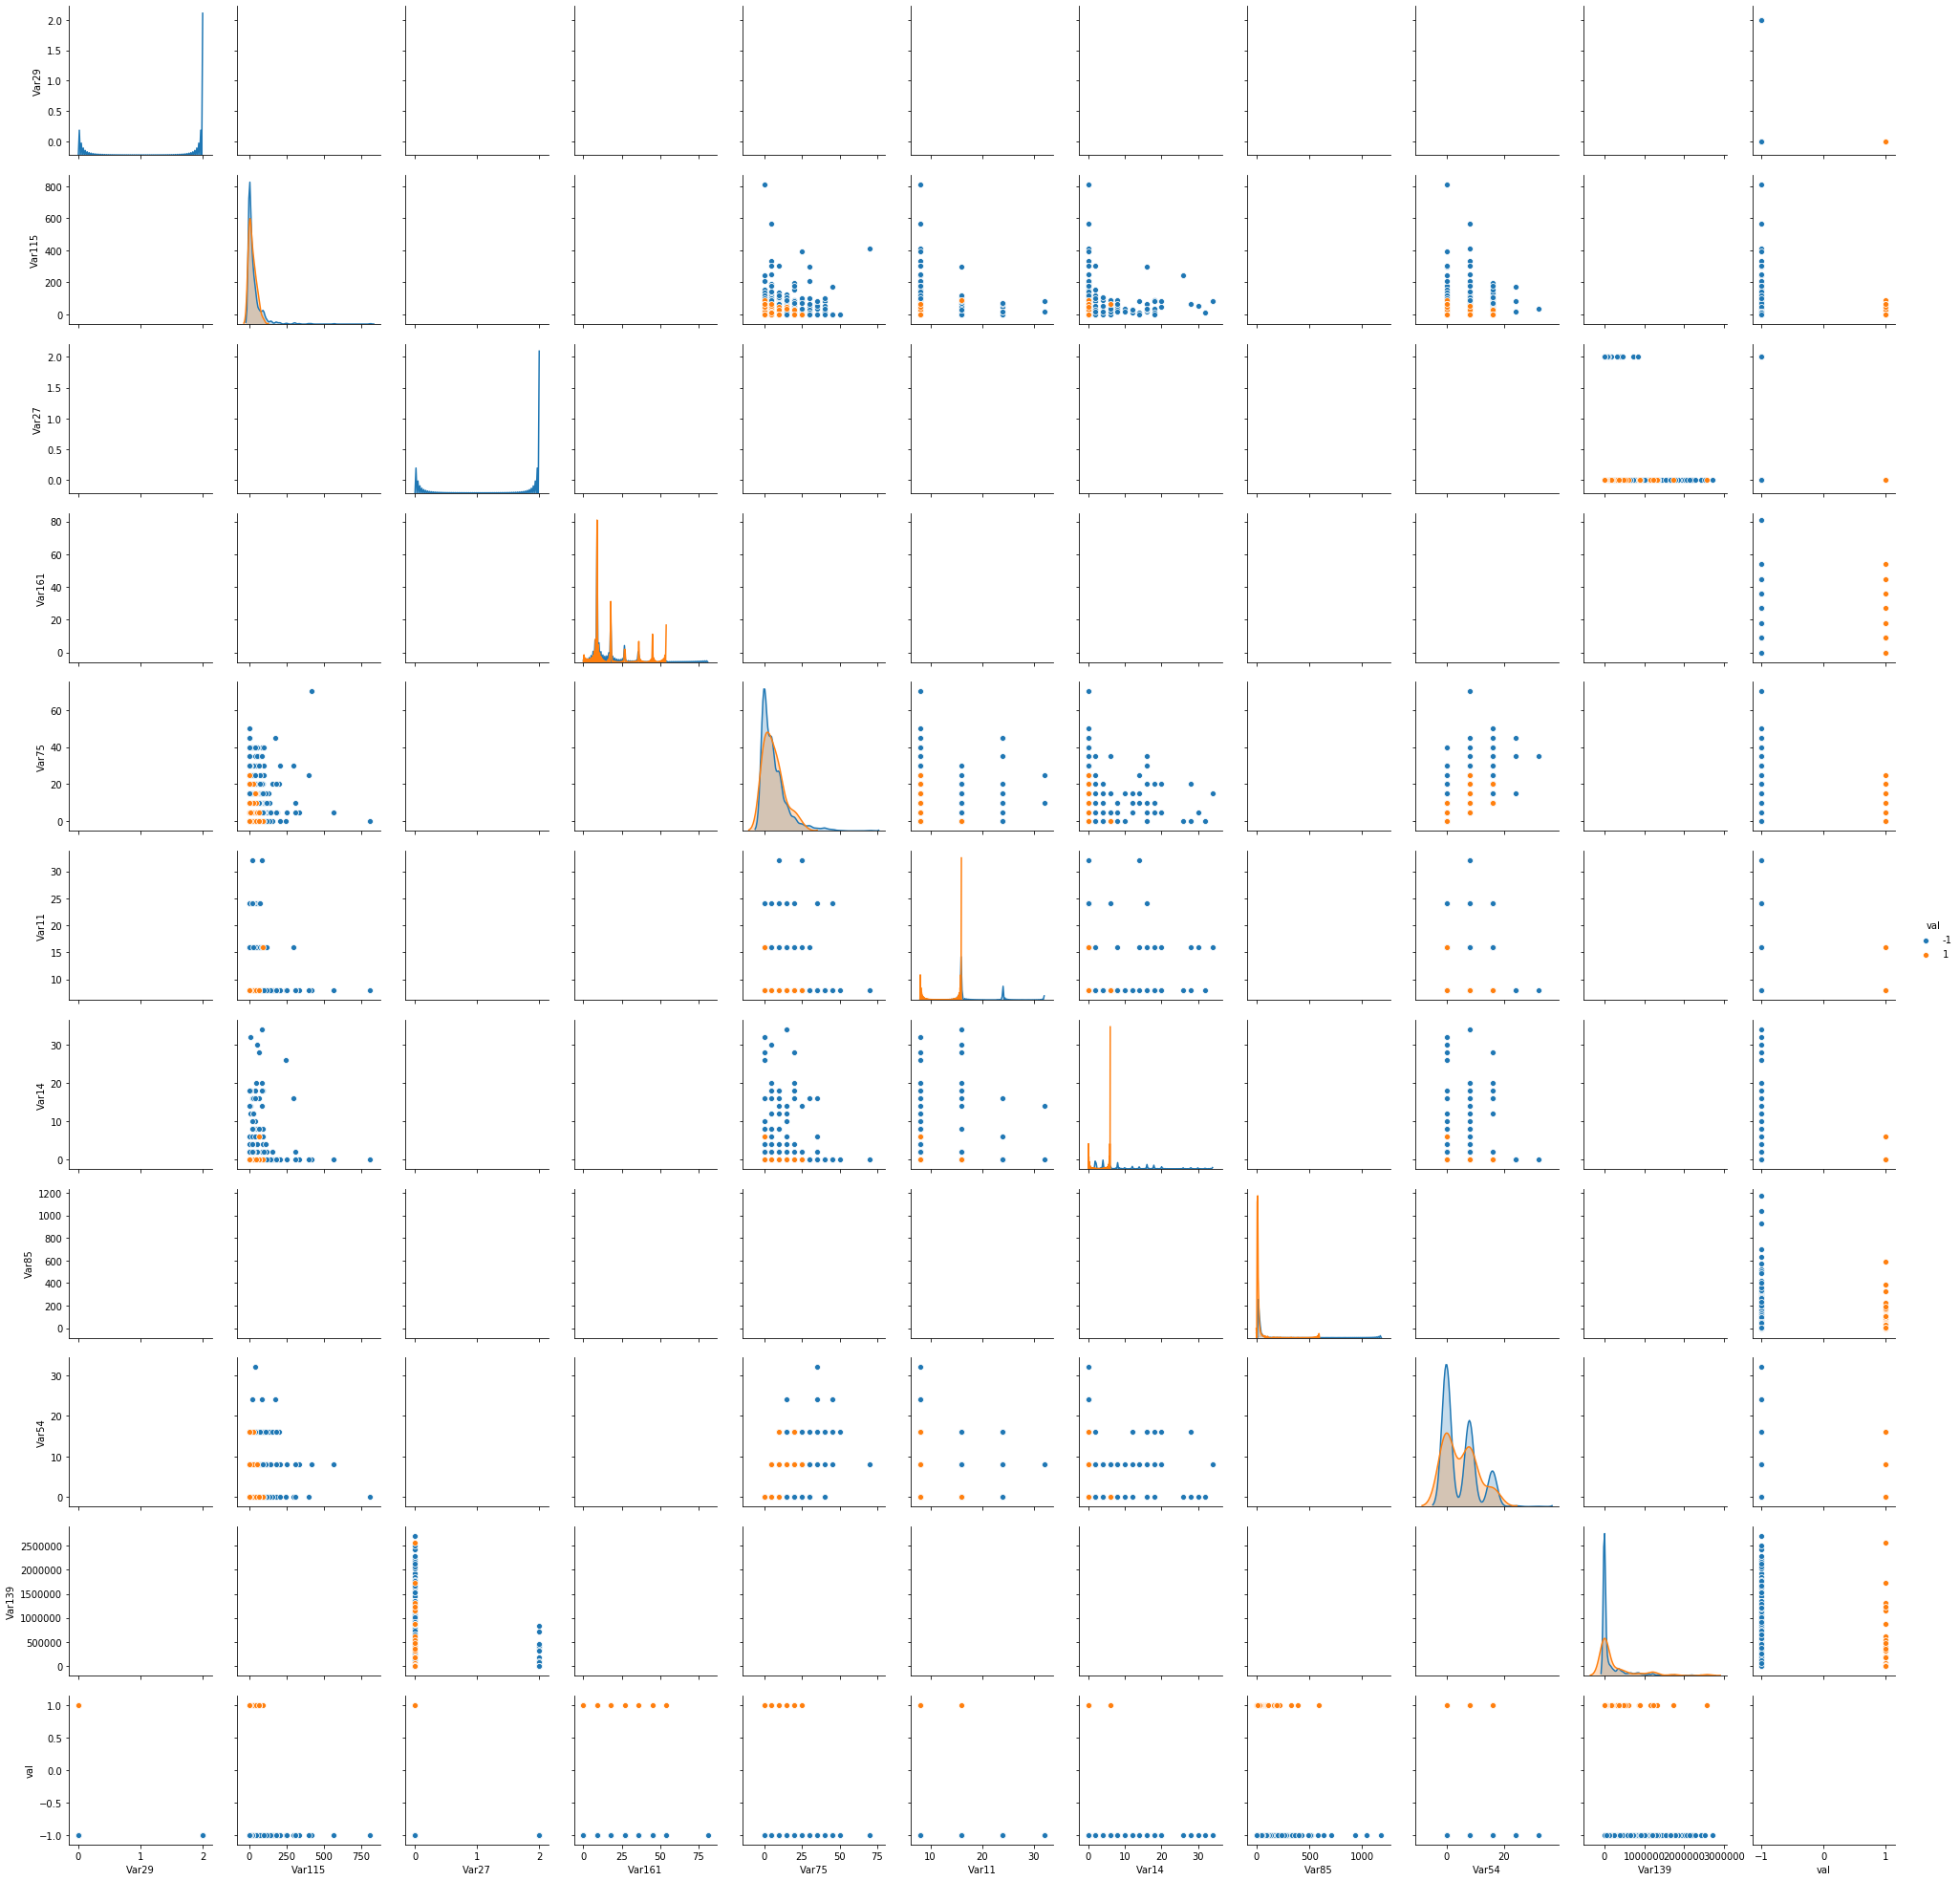

In [68]:
merged_df = pd.concat([data[random_cols], labels], axis = 1, sort=False)
sns.pairplot(merged_df, hue="val", diag_kind="kde")

6\. Проделайте аналогичные шаги для 10 числовых признаков, наименее сильно коррелирующих с целевой переменной.

In [69]:
less10_abs = numeric_corr.abs().sort_values(ascending = True)[:10]
less10 = numeric_corr[less10_abs.index]

Строим распределения в разрезе классов:

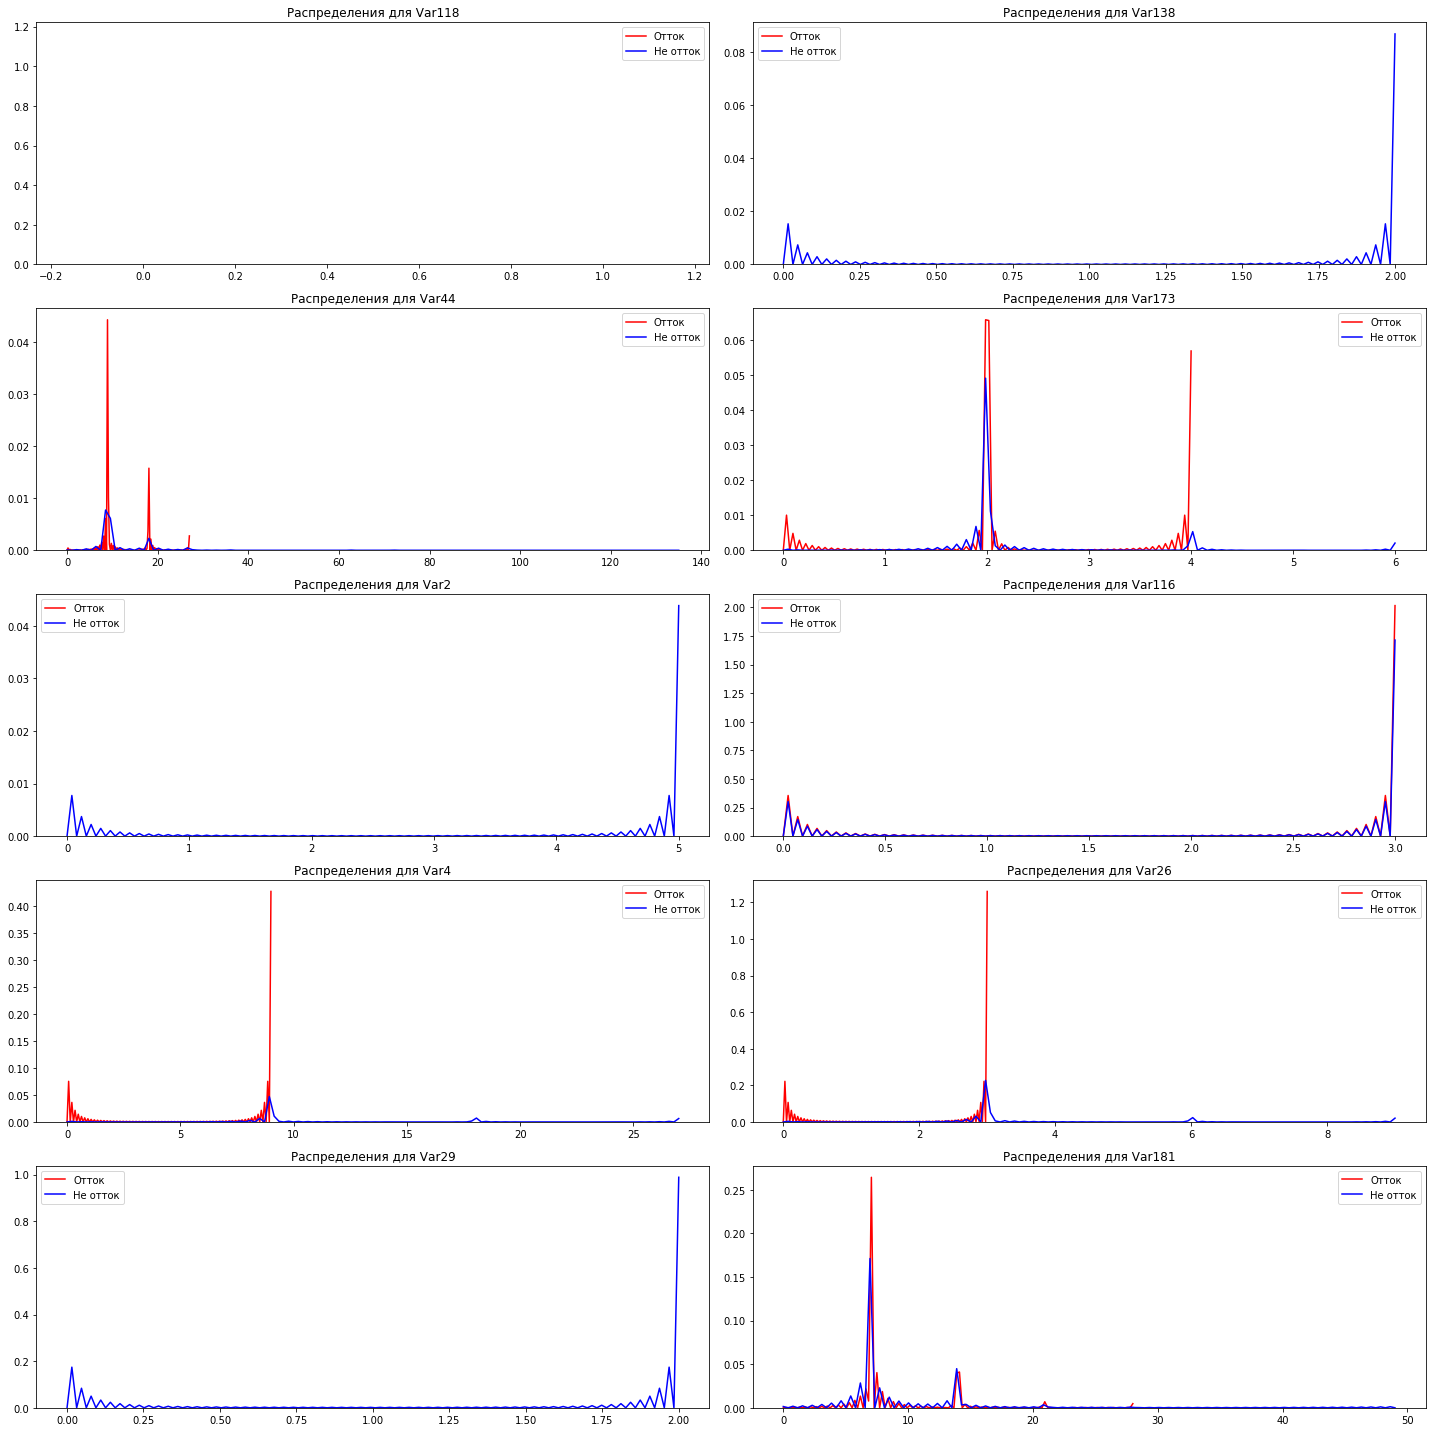

In [70]:
fig, axes = plt.subplots(5, 2, figsize = (20,20))

for i, var in enumerate(less10.index):
    var_churn = data[var].loc[labels['val'] == 1]
    var_not_churn = data[var].loc[labels['val'] == -1]
               
    sns.kdeplot(var_churn, color = 'r', ax = axes[int(i / 2) , i % 2], label = 'Отток')
    sns.kdeplot(var_not_churn, color = 'b', ax = axes[int(i / 2) , i % 2], label = 'Не отток')
    axes[int(i / 2), i % 2].set(title = 'Распределения для '+ var)
    
fig.tight_layout()

Отобразим объекты в координатах пар признаков:

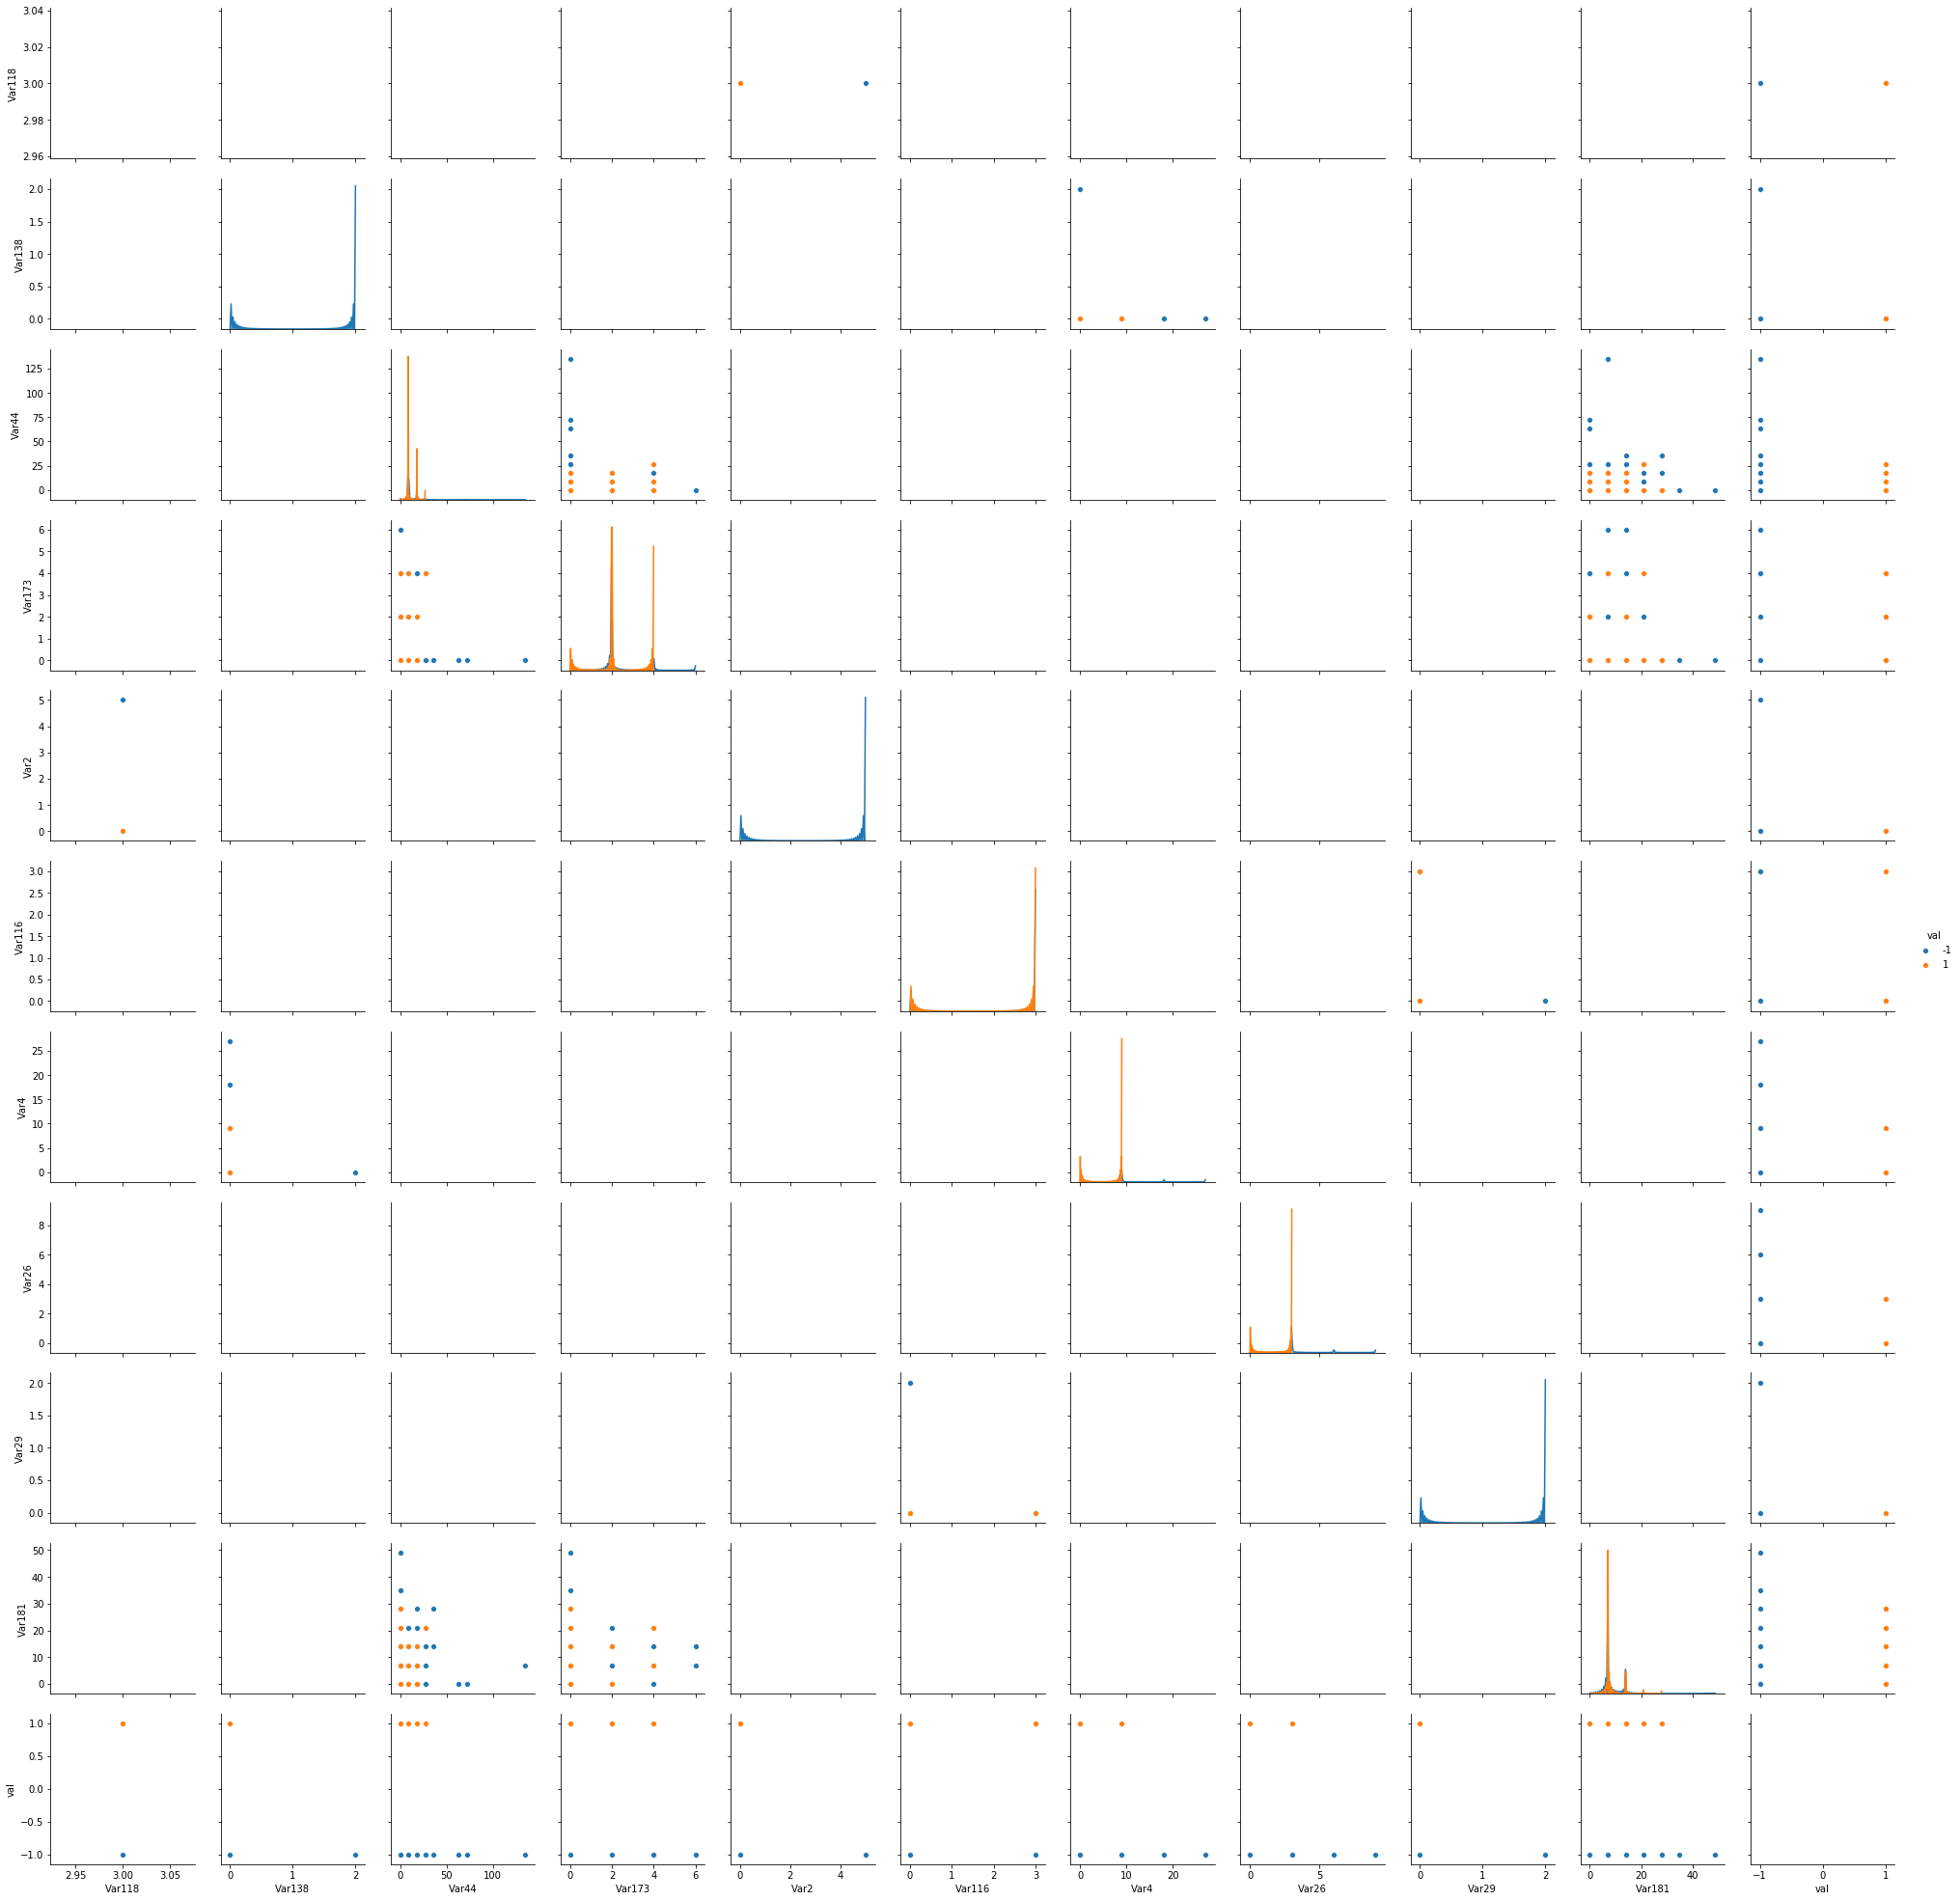

In [71]:
merged_df = pd.concat([data[less10.index], labels], axis = 1, sort=False)
sns.pairplot(merged_df, hue="val", diag_kind="kde")

7\. Посмотрите на категориальные переменные: постройте и сравните гистограммы значений категориальных переменных для разных классов.

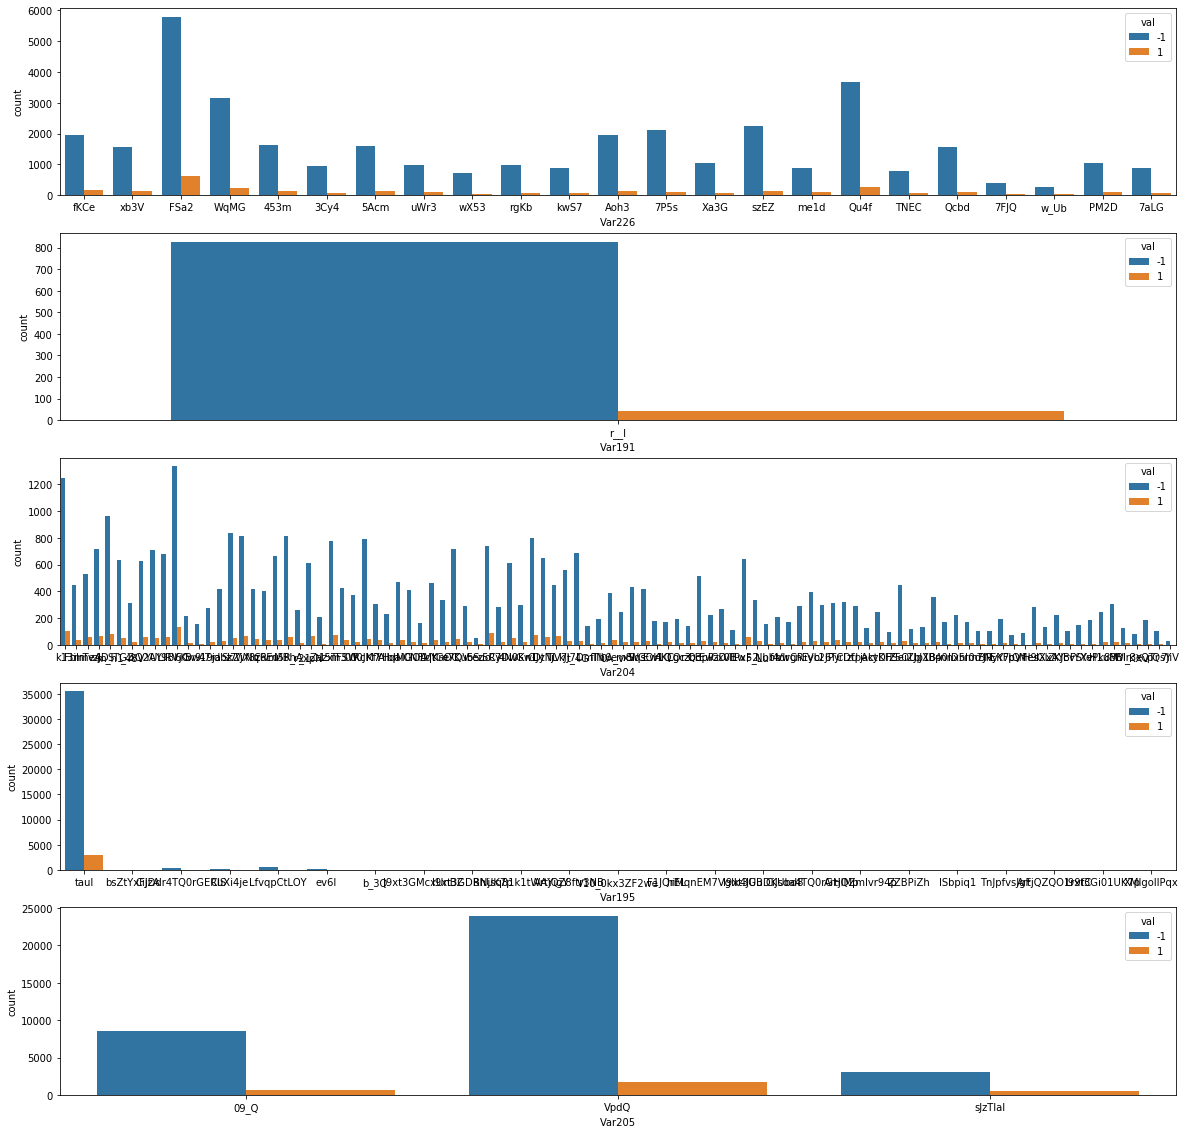

In [86]:
merged_df = pd.concat([data[categorical_cols], labels], axis = 1, sort = False)
fig, ax = plt.subplots(nrows = 5, figsize = (20, 20))
for index, col in enumerate(categorical_cols[:5]):
    sns.countplot(x = col, data = merged_df, hue = 'val', ax = ax[index])

8\. Проанализируйте полученные результаты:
* Какие выводы вы можете сделать? Заметили ли вы какие-нибудь интересные закономерности?
    Ответ: По количественным признакам можно увидеть некоторую закономерность. Например, признаки 5, 10, 33. С категориальными признаками намного все сложнее, но признаки 205, 204, 191, 226 могут быть наиболее полезны, там явно видно различие к целовой переменной.
    Вообще, в данных очень много пропусков, что очень сильно влияет на качество построенных распределений. Скорее всего, в дальнейшем потребуется работа с данными. Удаление точно не поможет, потребуется замена на среднее или нули.
* На основании полученных изображений и таблиц, предположите, какие переменные окажут наибольшее влияние (вклад) в модель?
    Ответ:признаки 5, 10, 33, 205, 204, 191, 226. 
 
* Какие переменные на ваш взгляд окажутся наименее полезными, шумовыми?
    Ответ: 38,113,116, 161, 173,181,195 -признаки крайне зашумлены.

* Как вы думаете, окажется ли отбор признаков полезным для построения модели?
    Ответ: В теории - да, но как говорилось выше очень много пропусков. Поэтому, если убрать большее число признаков, вохзможно качество модели сильно упадет. И нельзя отрицать, что убранные признаки могут быть полезны при создании новых признаков за счет их алгебрраических преобразований.

In [87]:
import pandas as pd
from sklearn.model_selection import train_test_split

In [88]:
data_train, hold_out_data, labels_train, hold_out_labels = train_test_split(data, labels, stratify=labels, test_size=0.3)

In [89]:
data_train.to_csv('train_data.csv', index=False)
labels_train.to_csv('train_labels.csv', index=False)
hold_out_data.to_csv('hold_out_data.csv', index=False)
hold_out_labels.to_csv('hold_out_labels.csv', index=False)

hold_out_data['labels'] = hold_out_labels.values
hold_out_data.to_csv('hold_out_data_labels.csv', index=False)

/anaconda2/envs/python3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
